In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR

In [2]:
#Safe LabelEncoder để tránh lỗi KeyError
class SafeLabelEncoder(LabelEncoder):
    def transform(self, values):
        return [np.where(self.classes_ == val)[0][0] if val in self.classes_ else -1 for val in values]

In [3]:
# 1. Đọc dữ liệu
train_df = pd.read_csv("../Dataset/712/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("../Dataset/712/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("../Dataset/712/test.csv", parse_dates=["date"])

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)


Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [4]:
# 2. Chuẩn bị dữ liệu
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values

X_valid = valid_df[features].values
y_valid = valid_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_valid = scaler_X.transform(X_valid)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [5]:
# 3. Khởi tạo và huấn luyện mô hình SVR
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train, y_train_scaled)

SVR(C=100, gamma=0.1)

In [6]:
# 4. Dự đoán và đánh giá
valid_preds_scaled = svm_model.predict(X_valid)
valid_preds = scaler_y.inverse_transform(valid_preds_scaled.reshape(-1, 1)).flatten()
y_valid_original = scaler_y.inverse_transform(y_valid_scaled.reshape(-1, 1)).flatten()

val_mae = mean_absolute_error(y_valid_original, valid_preds)
val_rmse = np.sqrt(mean_squared_error(y_valid_original, valid_preds))
val_r2 = r2_score(y_valid_original, valid_preds)
print(f"Validation - MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.2f}")

test_preds_scaled = svm_model.predict(X_test)
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

test_mae = mean_absolute_error(y_test_original, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_preds))
test_r2 = r2_score(y_test_original, test_preds)
print(f"Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")


Validation - MAE: 3398633.28, RMSE: 11294800.22, R²: 0.90
Test - MAE: 10950302.91, RMSE: 14927119.73, R²: 0.77


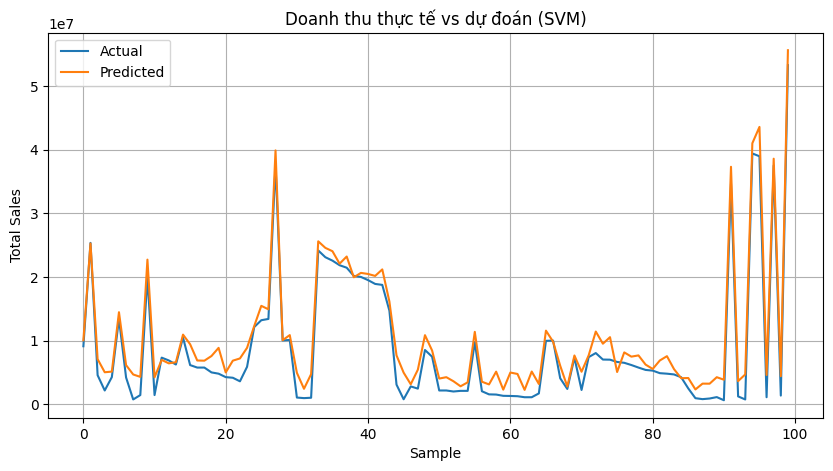

In [7]:
# 5. Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[:100], label='Actual')
plt.plot(test_preds[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán (SVM)')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [8]:
# 6. Dự đoán tương lai 30 ngày
last_date = test_df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30).strftime('%Y-%m-%d')

future_X_raw = test_df[features].iloc[-30:].values
future_X_scaled = scaler_X.transform(future_X_raw)
future_preds_scaled = svm_model.predict(future_X_scaled)
future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

future_df = pd.DataFrame({
    'date': pd.to_datetime(future_dates),
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

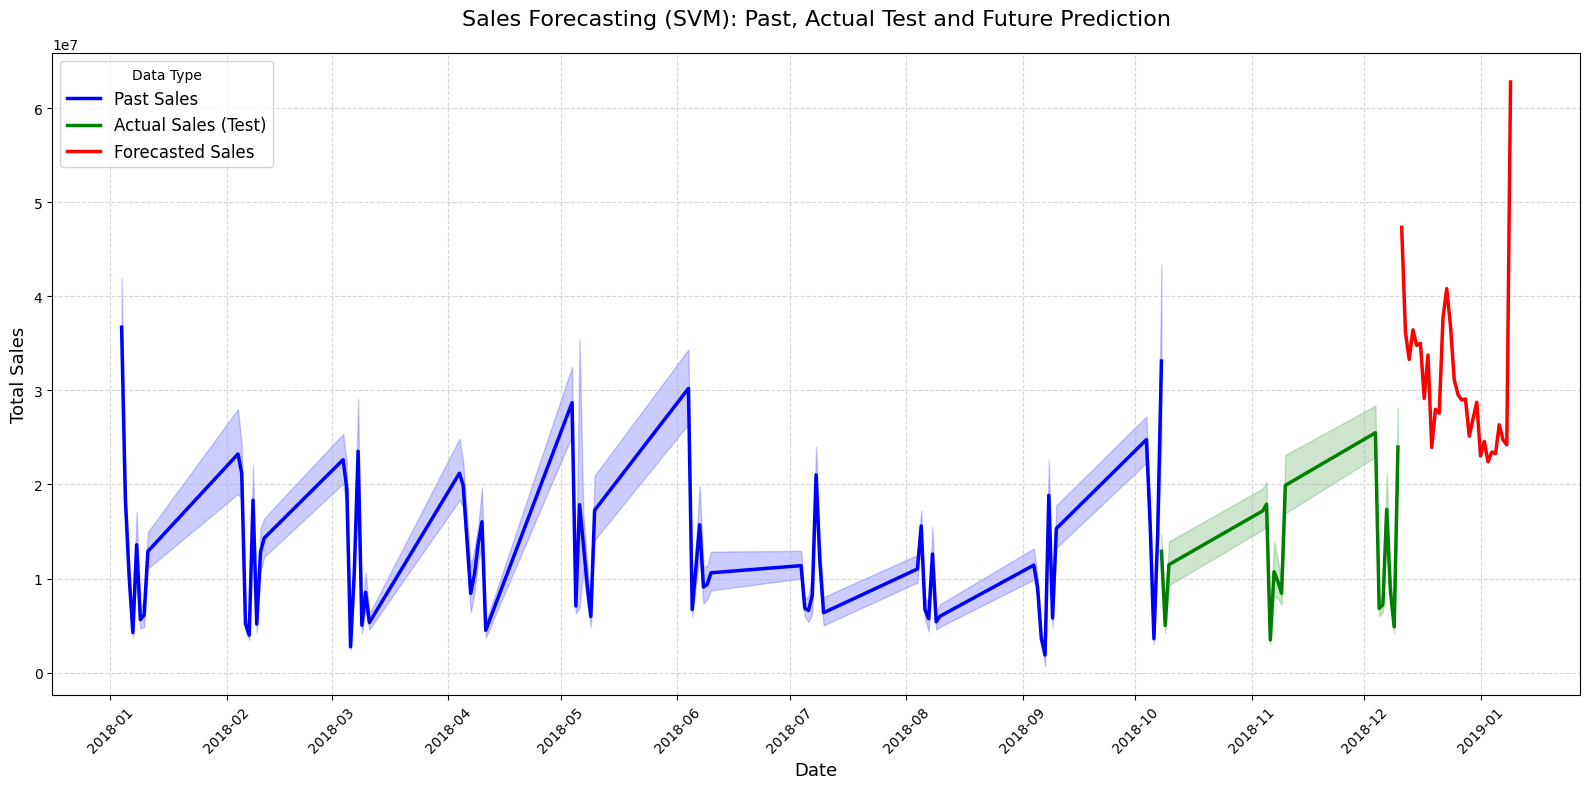

In [9]:
# 7. Visualization tổng thể
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'

combined_df = pd.concat([
    train_df[['date', 'total_sales', 'type']],
    valid_df[['date', 'total_sales', 'type']],
    test_df[['date', 'total_sales', 'type']],
    future_df
], ignore_index=True)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting (SVM): Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()